In [73]:
from pathlib import Path
from tqdm import trange

import torch
import torch.nn.functional as F

import taichi as ti

from differender.volume_raycaster import Raycaster
from differender.utils import get_rand_pos, in_circles, get_tf

from torchvtk.datasets import TorchDataset
from torchvtk.utils import TFGenerator, tex_from_pts, make_4d
from torchvtk.rendering import show_tf, plot_tf, plot_comp_render_tf

import matplotlib.pyplot as plt

In [100]:
def show_im(im, axs=None):
    if axs is None:
        fig, axs = plt.subplot_mosaic([['rgb', 'alpha', 'firsthit'],
                                        ['maxop', 'maxgrad', 'wysiwyp']], figsize=(15,10))
    axs['rgb'].imshow(im.squeeze()[:3].permute(1,2,0).cpu().numpy())
    axs['rgb'].set_title('Color')
    axs['alpha'].imshow(im.squeeze()[[3,3,3]].permute(1,2,0).cpu().numpy())
    axs['alpha'].set_title('Alpha')
    axs['firsthit'].imshow(im.squeeze()[[4,4,4]].permute(1,2,0).cpu().numpy())
    axs['firsthit'].set_title('First Hit')
    axs['maxop'].imshow(im.squeeze()[[5,5,5]].permute(1,2,0).cpu().numpy())
    axs['maxop'].set_title('Max Opacity')
    axs['maxgrad'].imshow(im.squeeze()[[6,6,6]].permute(1,2,0).cpu().numpy())
    axs['maxgrad'].set_title('Max Gradient')
    axs['wysiwyp'].imshow(im.squeeze()[[7,7,7]].permute(1,2,0).cpu().numpy())
    axs['wysiwyp'].set_title('WYSIWYP')
    
def show_hist(im, ax=None, title='Histogram', show_percentages=True):
    tit = f'{title}'
    x = torch.linspace(0.0, 1.0, BINS)
    hst = torch.histc(im, BINS, min=0.0, max=1.0).cpu()
    
    if show_percentages:
        tit = f'{tit}: Transparent: {hst[1:-1].sum()/im.numel():.1%}'
        tit = f'{tit} | Opaque: {hst[-1]/im.numel():.1%}'
        tit = f'{tit} | Visible: {1.0 - hst[0]/im.numel():.1%}'
    if ax is None:
        fig, ax = plt.subplots(1,1, figsize=(5,5))
        fig.title(tit)
    else:
        ax.set_title(tit)
    
    ax.bar(x, hst, width=1/BINS)
    

In [6]:
N_ITEMS = 100000
W, H = 512, 512
TF_RES = 256
BINS = 51
SR = 16.0 # Sampling rate

out_dir = Path('/run/meida/dome/Data/data/torchvtk/STDepth_data_multi')
ds = TorchDataset('/run/media/dome/Data/data/torchvtk/CQ500')
N_VOLUMES = len(ds)

In [3]:
tfgen = TFGenerator(colors='distinguishable', peakgen_kwargs={
    'max_num_peaks': 3,
    'height_range': (0.02, 0.4),
    'width_range': (0.005, 0.05),
    'use_hist': False
})

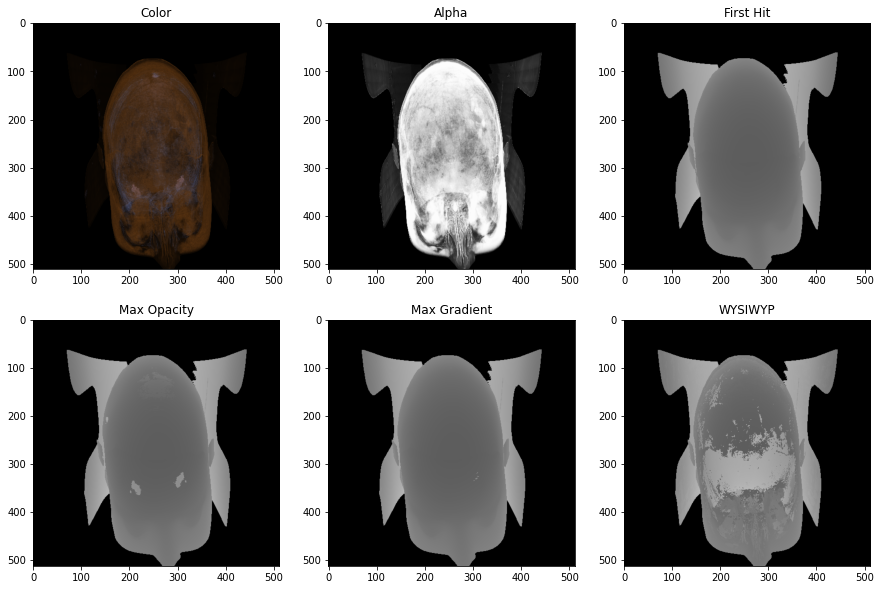

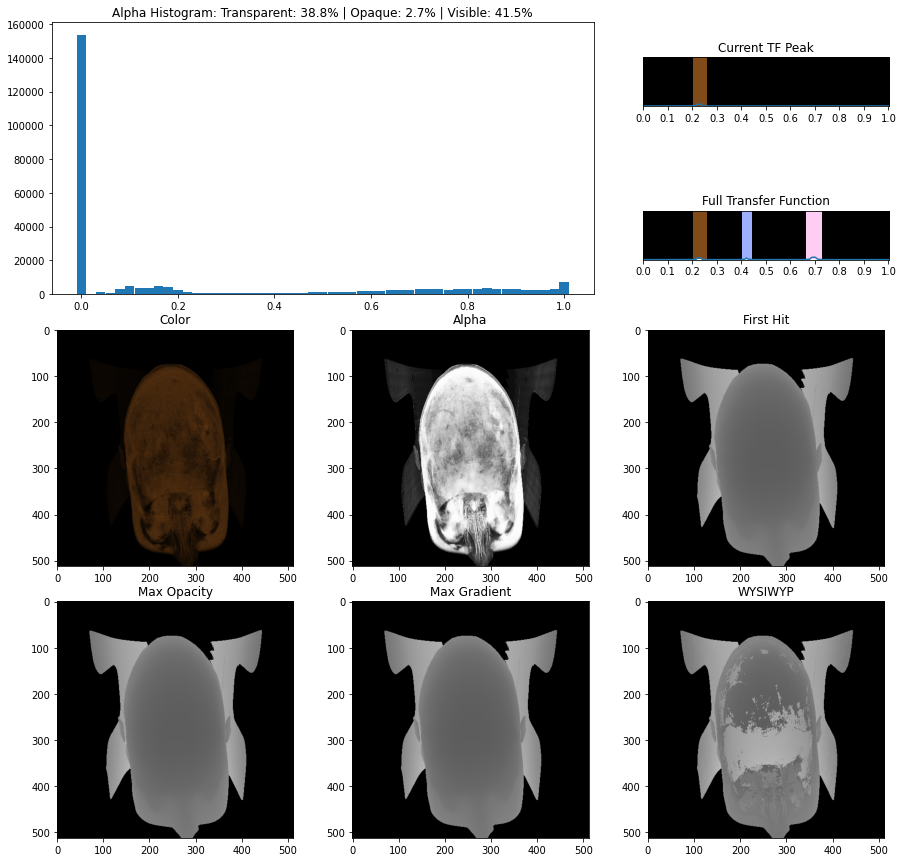

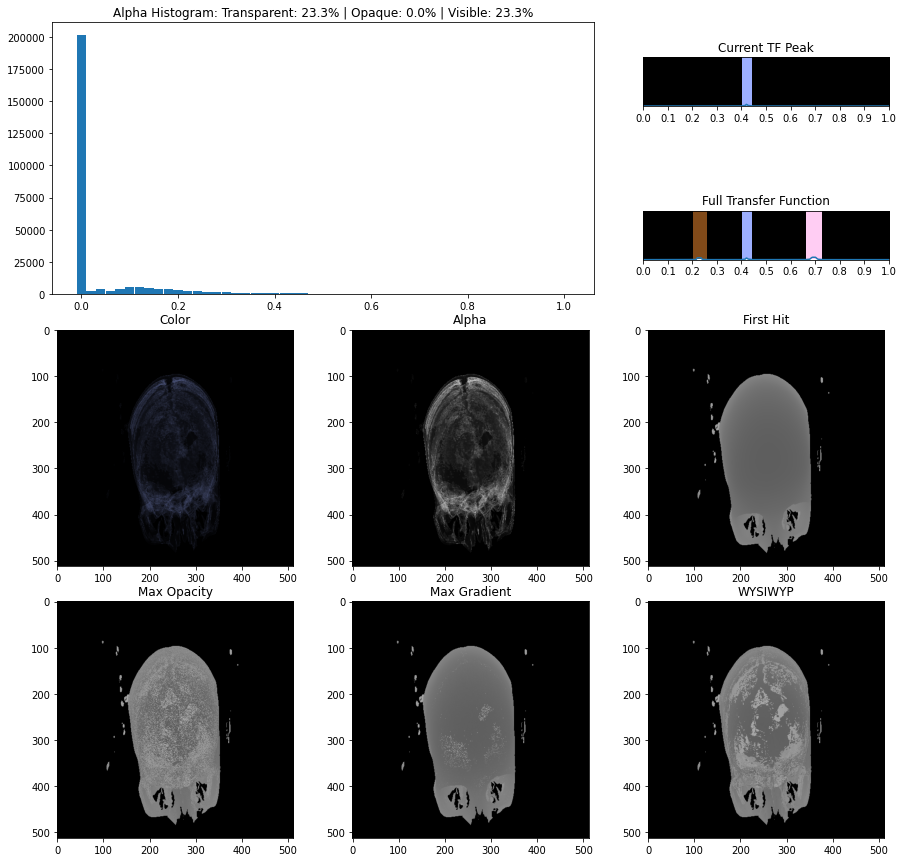

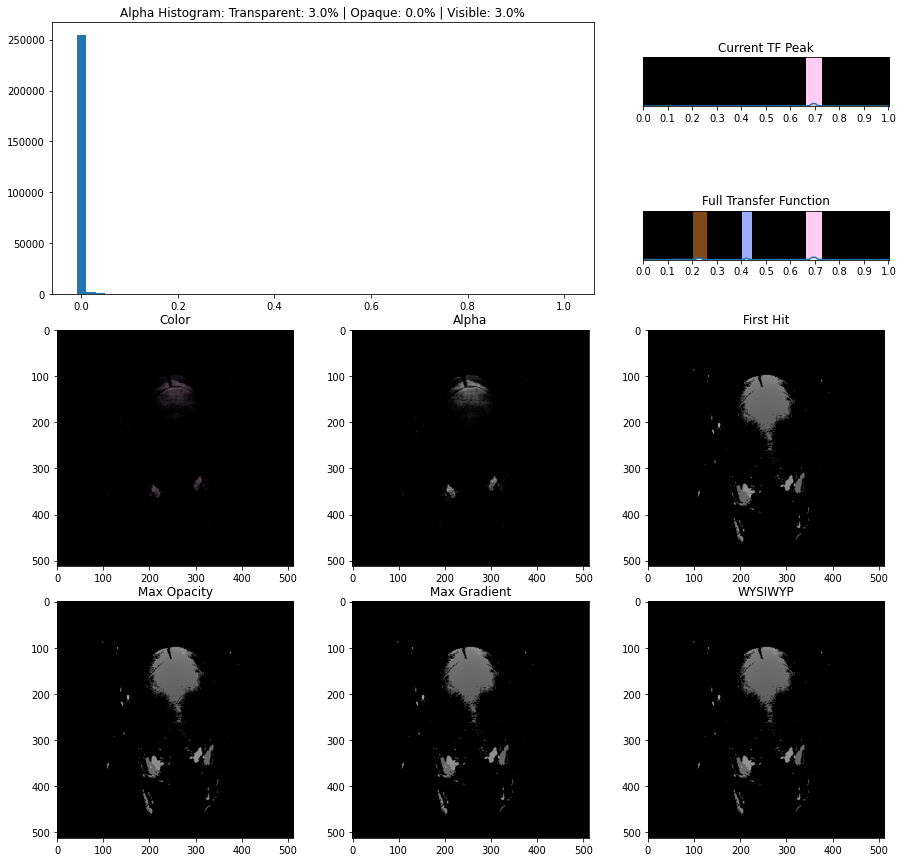

In [103]:
tf = tfgen.generate()
while len(tf) == 8: # single peak
    tf = tfgen.generate()
n_peaks = (len(tf)-2)//6
single_peaks = []
for i in range(n_peaks):
    peak = torch.cat([tf[[0]], tf[6*i+1 : 6*(i+1)+1], tf[[-1]]], dim=0)
    single_peaks.append({'pts': peak, 'tex': tex_from_pts(peak, TF_RES)})
    
rgbad_full = raycaster.raycast_nondiff(vol.float().cuda(), tex_from_pts(tf, TF_RES).float().cuda(),
                                       lf.float().cuda(), sampling_rate=SR).squeeze(0)
show_im(rgbad_full)

for p in single_peaks:
    rgbad = raycaster.raycast_nondiff(vol.float().cuda(), p['tex'].float().cuda(), lf.float().cuda(),                 sampling_rate=SR).squeeze(0)
    
    fig, ax = plt.subplot_mosaic([['hist', 'hist', 'tf1'], 
                                  ['hist', 'hist', 'tf2'], 
                                  ['rgb', 'alpha', 'firsthit'],
                                  ['maxop', 'maxgrad', 'wysiwyp']], figsize=(15,15), gridspec_kw={
        'width_ratios': [1.0, 1.0, 1.0], 'height_ratios': [0.5, 0.5, 1.0, 1.0]
    })
    show_hist(rgbad[3], ax['hist'], title='Alpha Histogram')
    show_tf(p['pts'], ax=ax['tf1'], title='Current TF Peak')
    show_tf(tf, ax=ax['tf2'], title='Full Transfer Function')
    show_im(rgbad, axs=ax)
    
    fig.show()

    

Percentage 0.02 < Alpha < 0.9:  17.7%
Percentage        Alpha > 0.98: 5.5%
Percentage visible (>=0.02):    23.2%


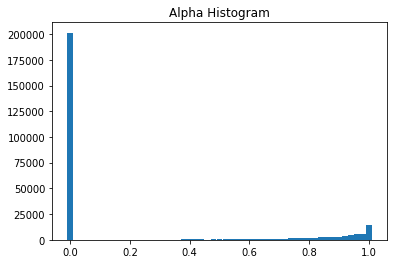

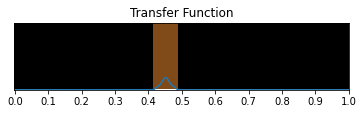

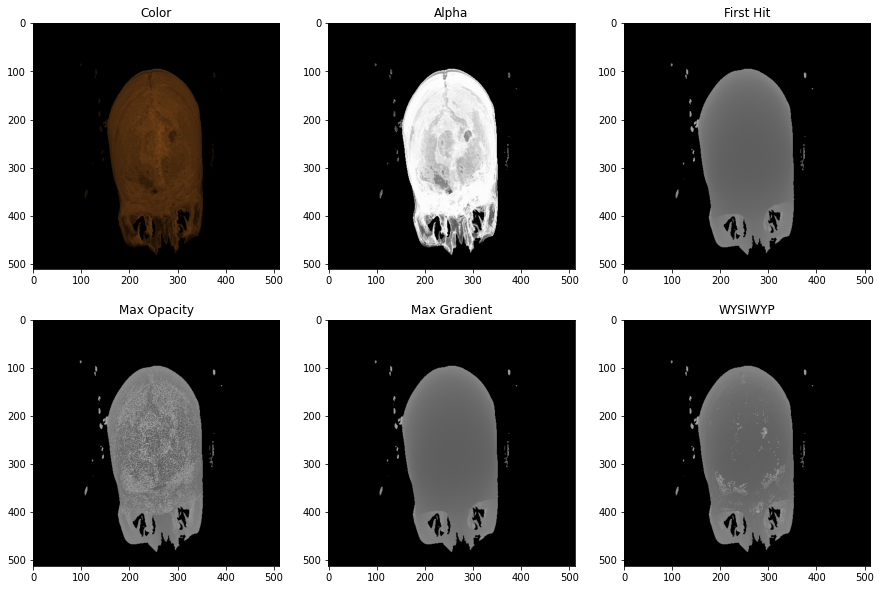

In [11]:
lf = in_circles(4.7)
tf = tex_from_pts(tfgen.generate(), TF_RES).float().to('cuda')
rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
x = torch.linspace(0.0, 1.0, BINS)
hst = torch.histc(rgbad[3], BINS, min=0.0, max=1.0).cpu()
print(f'Percentage 0.02 < Alpha < 0.9:  {hst[1:-1].sum()/rgbad[3].numel():.1%}')
print(f'Percentage        Alpha > 0.98: {hst[-1]/rgbad[3].numel():.1%}')
print(f'Percentage visible (>=0.02):    {1.0 - hst[0]/rgbad[3].numel():.1%}')
plt.bar(x, hst, width=1/BINS)
plt.title('Alpha Histogram')
plt.show()
plot_tf(tf, title='Transfer Function')
show_im(rgbad)

In [4]:
raycaster = None
skips = 0
for v in trange(N_VOLUMES):
    item = ds[v]
    vol = make_4d(item['vol']).float().to('cuda')
    nam = item['name']
    ti.reset()
    del raycaster
    raycaster = Raycaster(vol.shape[-3:], (W, H), TF_RES, 
        sampling_rate=SR, near=0.1, far=5.0, max_samples=1, ti_kwargs={'device_memory_fraction':0.5})
    for i in trange(N_ITEMS // N_VOLUMES):
        while True:
            lf = get_rand_pos(1).float().to('cuda')
            tf = get_tf('generate', TF_RES).float().to('cuda')
            rgbad = raycaster.raycast_nondiff(vol, tf, lf, sampling_rate=SR).squeeze(0)
            if (rgbad[3] > 0.0).float().mean() < 0.1 and (rgbad[4] > 0.0).float().mean() < 0.1:
                skips += 1
                print(f'Skipping another useless render ({skips})')
                continue
            else:
                torch.save({
                    'vol': nam,
                    'tf': tf.squeeze(0).cpu().float(),
                    'look_from': lf.squeeze(0).cpu().float(),
                    'rgba': rgbad[:4].cpu().half(),
                    'first_hit': rgbad[[4]].cpu().half(),
                    'max_opacity': rgbad[[5]].cpu().half(),
                    'max_gradient': rgbad[[6]].cpu().half(),
                    'wysiwyp': rgbad[[7]].cpu().half()
                }, out_dir/f'{nam}_{i}.pt')
                break

  0%|          | 0/395 [00:00<?, ?it/s]

[Taichi] Starting on arch=cuda



  0%|          | 0/253 [00:00<?, ?it/s]

Skipping another useless render (1)


  0%|          | 0/395 [00:10<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: '/run/meida/dome/Data/data/torchvtk/STDepth_data_multi/CQ500-CT-0_0.pt'